In [101]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os.path as path
import pickle
import collections


In [38]:
%matplotlib inline

### Camera Calibration

In [147]:
calibration_pkl = './camera_cal/calibration_data.pickle'

def calibrate_camera(images_dir):
    if path.exists(calibration_pkl):
        with open(calibration_pkl, 'rb') as f:
                calibration = pickle.load(f)
                return calibration
        
    objp = np.zeros((6 * 9, 3), np.float32)
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d points in real world space
    imgpoints = []  # 2d points in image plane.

    images = glob.glob(path.join(images_dir, 'calibration*.jpg'))
    for filename in images:
        img = cv2.imread(filename)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        pattern_found, corners = cv2.findChessboardCorners(gray, (9, 6), None)

        if pattern_found is True:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    with open(calibration_pkl, 'wb') as dump_file:
        pickle.dump((ret, mtx, dist, rvecs, tvecs), dump_file)

    return ret, mtx, dist, rvecs, tvecs


def undistort(img, mtx, dist):
    frame_undistorted = cv2.undistort(img, mtx, dist, newCameraMatrix=mtx)
    return frame_undistorted

In [284]:
ret, mtx, dist, rvecs, tvecs = calibrate_camera(images_dir='camera_cal')
img = cv2.imread('test_images/test4.jpg')
img_undistorted = undistort(img, mtx, dist)
# cv2.imwrite('img/test_calibration_before.jpg', img)
# cv2.imwrite('img/test_calibration_after.jpg', img_undistorted)

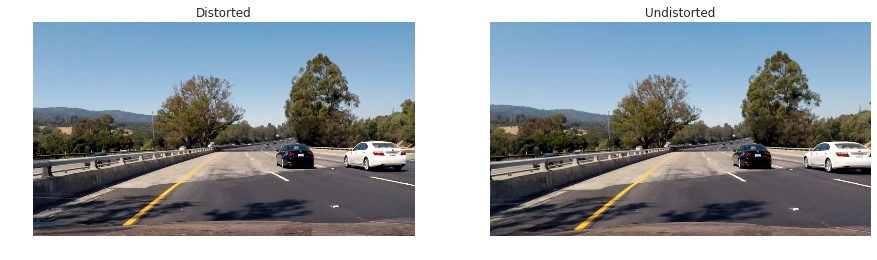

In [287]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(121)
ax2 =  fig.add_subplot(122)
ax1.set_axis_off()
ax2.set_axis_off()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title("Distorted")
ax2.set_title("Undistorted")
ax2.imshow(cv2.cvtColor(img_undistorted, cv2.COLOR_BGR2RGB))

### Image Binarization

In [275]:
def HSV_select(image, min_values, max_values):
    HSV = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    min_th = np.all(HSV > min_values, axis=2)
    max_th = np.all(HSV < max_values, axis=2)
    out = np.logical_and(min_th, max_th)
    return out


def sobel_select(image, kernel_size):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
    sobel_mag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    sobel_mag = np.uint8(sobel_mag / np.max(sobel_mag) * 255)
    _, sobel_mag = cv2.threshold(sobel_mag, 75, 1, cv2.THRESH_BINARY)
    return sobel_mag.astype(bool)


def equalized_grayscale(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    eq_global = cv2.equalizeHist(gray)
    _, th = cv2.threshold(eq_global, thresh=250, maxval=255, type=cv2.THRESH_BINARY)
    return th


def binarize(img, print_images=False):
    # threshold that works well for detecting yellow lanes
    HSV_min = np.array([0, 70, 70])
    HSV_max = np.array([50, 255, 255])
    
    h, w = img.shape[:2]

    binary = np.zeros(shape=(h, w), dtype=np.uint8)

    # extract yallow in HSV color space
    HSV_mask = HSV_select(img, HSV_min, HSV_max)
    binary = np.logical_or(binary, HSV_mask)

    # highlight white lines by thresholding the equalized frame
    white_mask = equalized_grayscale(img)
    binary = np.logical_or(binary, white_mask)

    # get Sobel
    sobel_mask = sobel_select(img, kernel_size=9)
    binary = np.logical_or(binary, sobel_mask)

        # apply a light morphology to "fill the gaps" in the binary image
    kernel = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(binary.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    
    if print_images:
#         plt.figure(figsize=(10,10))
        f, ax = plt.subplots(2, 3,figsize=(15,6))
        f.set_facecolor('white')
        ax[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax[0, 0].set_title('input_frame')
        ax[0, 0].set_axis_off()
        ax[0, 0].set_axis_bgcolor('red')
        ax[0, 1].imshow(white_mask, cmap='gray')
        ax[0, 1].set_title('white mask')
        ax[0, 1].set_axis_off()

        ax[0, 2].imshow(HSV_mask, cmap='gray')
        ax[0, 2].set_title('yellow mask')
        ax[0, 2].set_axis_off()

        ax[1, 0].imshow(sobel_mask, cmap='gray')
        ax[1, 0].set_title('sobel mask')
        ax[1, 0].set_axis_off()

        ax[1, 1].imshow(binary, cmap='gray')
        ax[1, 1].set_title('Final Binary')
        ax[1, 1].set_axis_off()

#         ax[1, 2].imshow(closing, cmap='gray')
#         ax[1, 2].set_title('after closure')
        ax[1, 2].set_axis_off()
        plt.show()
        
    return closing

#     return binary.astype(np.uint8)


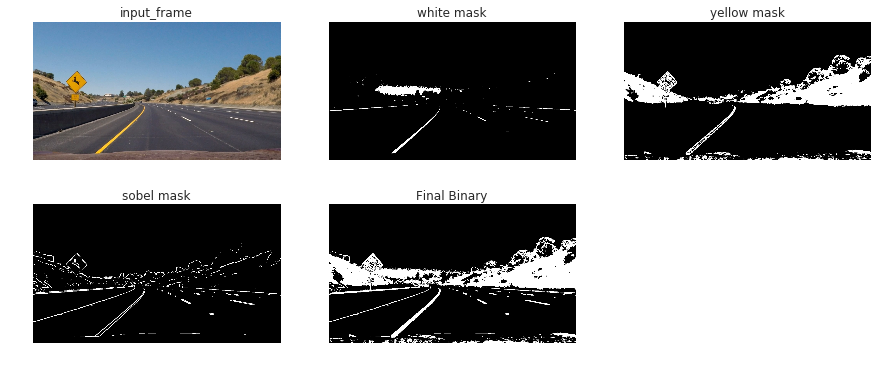

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [280]:
test_images = glob.glob('test_images/*.jpg')
# for test_image in test_images:
#     img = cv2.imread(test_image)
#     binarize(img=img, verbose=True)

img = cv2.imread("test_images/test2.jpg")
binarize(img, True)

### Perspective view

In [188]:
def perpective(img, print_images=False):
    h, w = img.shape[:2]

    src = np.float32([[w, h-15], [0, h-15], [546, 460], [732, 460]])
    dst = np.float32([[w, h], [0, h], [0, 0], [w, 0]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(img, M, (w, h), flags=cv2.INTER_LINEAR)

    if print_images:
        f, ax = plt.subplots(1, 2,figsize=(15,10))
        f.set_facecolor('white')
        ax[0].set_title('Before perspective transform')
        ax[0].imshow(img, cmap='gray')
        for point in src:
            ax[0].plot(*point, '.')
        ax[1].set_title('After perspective transform')
        ax[1].imshow(warped, cmap='gray')
        for point in dst:
            ax[1].plot(*point, '.')
        for axis in ax:
            axis.set_axis_off()
        plt.show()

    return warped, M, Minv


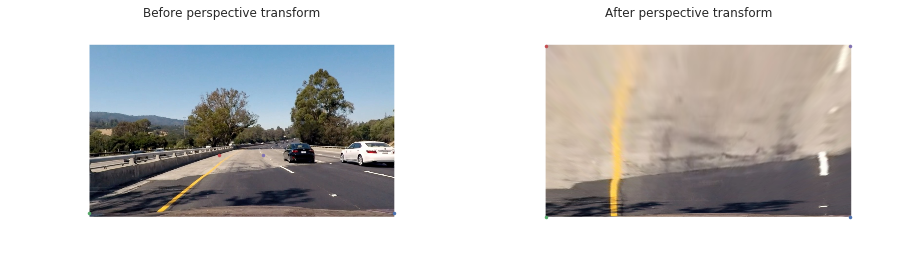

In [248]:
# show result on test images
# for test_img in glob.glob('test_images/*.jpg'):
test_img = "test_images/test4.jpg"
img = cv2.imread(test_img)
img_undistorted = undistort(img, mtx, dist)
img_binary = binarize(img_undistorted)
img_birdeye, M, Minv = perpective(cv2.cvtColor(img_undistorted, cv2.COLOR_BGR2RGB), True)

### Lane detection

In [236]:
ym_per_pix = 30 / 720   # meters per pixel in y dimension
xm_per_pix = 3.7 / 700  # meters per pixel in x dimension
time_window = 15        # results are averaged over this number of frames

In [237]:
def sliding_windows(birdeye_binary, line_lt, line_rt, n_windows=9, print_image=False):
    height, width = birdeye_binary.shape

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(birdeye_binary[height//2:-30, :], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((birdeye_binary, birdeye_binary, birdeye_binary)) * 255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = len(histogram) // 2
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(height / n_windows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = birdeye_binary.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    margin = 100  # width of the windows +/- margin
    minpix = 50   # minimum number of pixels found to recenter window

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(n_windows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = height - (window + 1) * window_height
        win_y_high = height - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xleft_low)
                          & (nonzero_x < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xright_low)
                           & (nonzero_x < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzero_x[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzero_x[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    line_lt.all_x, line_lt.all_y = nonzero_x[left_lane_inds], nonzero_y[left_lane_inds]
    line_rt.all_x, line_rt.all_y = nonzero_x[right_lane_inds], nonzero_y[right_lane_inds]

    detected = True
    if not list(line_lt.all_x) or not list(line_lt.all_y):
        left_fit_pixel = line_lt.last_fit_pixel
        left_fit_meter = line_lt.last_fit_meter
        detected = False
    else:
        left_fit_pixel = np.polyfit(line_lt.all_y, line_lt.all_x, 2)
        left_fit_meter = np.polyfit(line_lt.all_y * ym_per_pix, line_lt.all_x * xm_per_pix, 2)

    if not list(line_rt.all_x) or not list(line_rt.all_y):
        right_fit_pixel = line_rt.last_fit_pixel
        right_fit_meter = line_rt.last_fit_meter
        detected = False
    else:
        right_fit_pixel = np.polyfit(line_rt.all_y, line_rt.all_x, 2)
        right_fit_meter = np.polyfit(line_rt.all_y * ym_per_pix, line_rt.all_x * xm_per_pix, 2)

    line_lt.update_line(left_fit_pixel, left_fit_meter, detected=detected)
    line_rt.update_line(right_fit_pixel, right_fit_meter, detected=detected)

    # Generate x and y values for plotting
    ploty = np.linspace(0, height - 1, height)
    left_fitx = left_fit_pixel[0] * ploty ** 2 + left_fit_pixel[1] * ploty + left_fit_pixel[2]
    right_fitx = right_fit_pixel[0] * ploty ** 2 + right_fit_pixel[1] * ploty + right_fit_pixel[2]

    out_img[nonzero_y[left_lane_inds], nonzero_x[left_lane_inds]] = [255, 0, 0]
    out_img[nonzero_y[right_lane_inds], nonzero_x[right_lane_inds]] = [0, 0, 255]

    if print_image:
        f, ax = plt.subplots(1, 2, figsize=(15,6),  subplot_kw={'xticks': [], 'yticks': []})
        f.set_facecolor('white')
        ax[0].imshow(birdeye_binary, cmap='gray')
        ax[1].imshow(out_img)
        ax[1].plot(left_fitx, ploty, color='yellow')
        ax[1].plot(right_fitx, ploty, color='yellow')
        ax[1].set_xlim(0, 1280)
        ax[1].set_ylim(720, 0)

        plt.show()

    return line_lt, line_rt, out_img

In [289]:
def approx_by_previous_fits(birdeye_binary, line_lt, line_rt, print_image=False):
    """
    This function uses previously detected lane-lines to
    search of lane-lines in the current frame.
    """

    height, width = birdeye_binary.shape

    left_fit_pixel = line_lt.last_fit_pixel
    right_fit_pixel = line_rt.last_fit_pixel

    nonzero = birdeye_binary.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    margin = 100
    left_lane_inds = (
    (nonzero_x > (left_fit_pixel[0] * (nonzero_y ** 2) + left_fit_pixel[1] * nonzero_y + left_fit_pixel[2] - margin)) & (
    nonzero_x < (left_fit_pixel[0] * (nonzero_y ** 2) + left_fit_pixel[1] * nonzero_y + left_fit_pixel[2] + margin)))
    right_lane_inds = (
    (nonzero_x > (right_fit_pixel[0] * (nonzero_y ** 2) + right_fit_pixel[1] * nonzero_y + right_fit_pixel[2] - margin)) & (
    nonzero_x < (right_fit_pixel[0] * (nonzero_y ** 2) + right_fit_pixel[1] * nonzero_y + right_fit_pixel[2] + margin)))

    # Extract left and right line pixel positions
    line_lt.all_x, line_lt.all_y = nonzero_x[left_lane_inds], nonzero_y[left_lane_inds]
    line_rt.all_x, line_rt.all_y = nonzero_x[right_lane_inds], nonzero_y[right_lane_inds]

    detected = True
    if not list(line_lt.all_x) or not list(line_lt.all_y):
        left_fit_pixel = line_lt.last_fit_pixel
        left_fit_meter = line_lt.last_fit_meter
        detected = False
    else:
        left_fit_pixel = np.polyfit(line_lt.all_y, line_lt.all_x, 2)
        left_fit_meter = np.polyfit(line_lt.all_y * ym_per_pix, line_lt.all_x * xm_per_pix, 2)

    if not list(line_rt.all_x) or not list(line_rt.all_y):
        right_fit_pixel = line_rt.last_fit_pixel
        right_fit_meter = line_rt.last_fit_meter
        detected = False
    else:
        right_fit_pixel = np.polyfit(line_rt.all_y, line_rt.all_x, 2)
        right_fit_meter = np.polyfit(line_rt.all_y * ym_per_pix, line_rt.all_x * xm_per_pix, 2)

    line_lt.update_line(left_fit_pixel, left_fit_meter, detected=detected)
    line_rt.update_line(right_fit_pixel, right_fit_meter, detected=detected)

    # Generate x and y values for plotting
    ploty = np.linspace(0, height - 1, height)
    left_fitx = left_fit_pixel[0] * ploty ** 2 + left_fit_pixel[1] * ploty + left_fit_pixel[2]
    right_fitx = right_fit_pixel[0] * ploty ** 2 + right_fit_pixel[1] * ploty + right_fit_pixel[2]

    # Create an image to draw on and an image to show the selection window
    img_fit = np.dstack((birdeye_binary, birdeye_binary, birdeye_binary)) * 255
    window_img = np.zeros_like(img_fit)

    # Color in left and right line pixels
    img_fit[nonzero_y[left_lane_inds], nonzero_x[left_lane_inds]] = [255, 0, 0]
    img_fit[nonzero_y[right_lane_inds], nonzero_x[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    result = cv2.addWeighted(img_fit, 1, window_img, 0.3, 0)

    if print_image:
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

        plt.show()

    return line_lt, line_rt, img_fit

In [239]:
def blend_with_road(img_undistorted, Minv, line_lt, line_rt, keep_state):
    """
    Draw both the drivable lane area and the detected lane-lines 
    onto the original (undistorted) frame.
    """
    height, width, _ = img_undistorted.shape

    left_fit = line_lt.average_fit if keep_state else line_lt.last_fit_pixel
    right_fit = line_rt.average_fit if keep_state else line_rt.last_fit_pixel

    # Generate x and y values for plotting
    ploty = np.linspace(0, height - 1, height)
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    # draw road as green polygon on original frame
    road_warp = np.zeros_like(img_undistorted, dtype=np.uint8)
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(road_warp, np.int_([pts]), (0, 255, 0))
    road_dewarped = cv2.warpPerspective(road_warp, Minv, (width, height))  # Warp back to original image space

    blend_onto_road = cv2.addWeighted(img_undistorted, 1., road_dewarped, 0.3, 0)

    # now separately draw solid lines to highlight them
    line_warp = np.zeros_like(img_undistorted)
    line_warp = line_lt.draw(line_warp, color=(255, 0, 0), average=keep_state)
    line_warp = line_rt.draw(line_warp, color=(255, 0, 0), average=keep_state)
    line_dewarped = cv2.warpPerspective(line_warp, Minv, (width, height))

    lines_mask = blend_onto_road.copy()
    idx = np.any([line_dewarped != 0][0], axis=2)
    lines_mask[idx] = line_dewarped[idx]

    blend_onto_road = cv2.addWeighted(src1=lines_mask, alpha=0.8, src2=blend_onto_road, beta=0.5, gamma=0.)

    return blend_onto_road


In [246]:
class Line:
    def __init__(self, buffer_len=15):

        # flag to mark if the line was detected the last iteration
        self.detected = False

        # polynomial coefficients fitted on the last iteration
        self.last_fit_pixel = None
        self.last_fit_meter = None

        # list of polynomial coefficients of the last N iterations
        self.recent_fits_pixel = collections.deque(maxlen=buffer_len)
        self.recent_fits_meter = collections.deque(maxlen=2 * buffer_len)

        self.radius_of_curvature = None

        # store all pixels coords (x, y) of line detected
        self.all_x = None
        self.all_y = None

    def update_line(self, new_fit_pixel, new_fit_meter, detected, clear_buffer=False):
        """
        Update Line with new fitted coefficients.
        :param new_fit_pixel: new polynomial coefficients (pixel)
        :param new_fit_meter: new polynomial coefficients (meter)
        :param detected: if the Line was detected or inferred
        :param clear_buffer: if True, reset state
        :return: None
        """
        self.detected = detected

        if clear_buffer:
            self.recent_fits_pixel = []
            self.recent_fits_meter = []

        self.last_fit_pixel = new_fit_pixel
        self.last_fit_meter = new_fit_meter

        self.recent_fits_pixel.append(self.last_fit_pixel)
        self.recent_fits_meter.append(self.last_fit_meter)

    def draw(self, mask, color=(255, 0, 0), line_width=50, average=False):
        """
        Draw the line on a color mask image.
        """
        h, w, c = mask.shape

        plot_y = np.linspace(0, h - 1, h)
        coeffs = self.average_fit if average else self.last_fit_pixel

        line_center = coeffs[0] * plot_y ** 2 + coeffs[1] * plot_y + coeffs[2]
        line_left_side = line_center - line_width // 2
        line_right_side = line_center + line_width // 2

        # Some magic here to recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array(list(zip(line_left_side, plot_y)))
        pts_right = np.array(np.flipud(list(zip(line_right_side, plot_y))))
        pts = np.vstack([pts_left, pts_right])

        # Draw the lane onto the warped blank image
        return cv2.fillPoly(mask, [np.int32(pts)], color)

    @property
    # average of polynomial coefficients of the last N iterations
    def average_fit(self):
        return np.mean(self.recent_fits_pixel, axis=0)

    @property
    # radius of curvature of the line (averaged)
    def curvature(self):
        y_eval = 0
        coeffs = self.average_fit
        return ((1 + (2 * coeffs[0] * y_eval + coeffs[1]) ** 2) ** 1.5) / np.absolute(2 * coeffs[0])

    @property
    # radius of curvature of the line (averaged)
    def curvature_meter(self):
        y_eval = 0
        coeffs = np.mean(self.recent_fits_meter, axis=0)
        return ((1 + (2 * coeffs[0] * y_eval + coeffs[1]) ** 2) ** 1.5) / np.absolute(2 * coeffs[0])


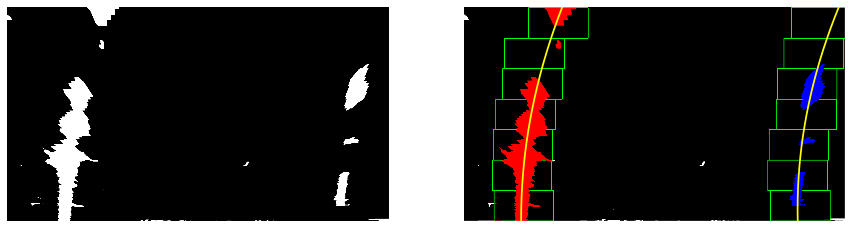

In [281]:
line_lt, line_rt = Line(buffer_len=10), Line(buffer_len=10)
img = cv2.imread("test_images/test5.jpg")
img_undistorted = undistort(img, mtx, dist)
img_binary = binarize(img_undistorted)
img_birdeye, M, Minv = perpective(img_binary)
line_lt, line_rt, img_out = sliding_windows(img_birdeye, line_lt, line_rt, n_windows=7, print_image=True)

In [242]:
def print_final_frame(blend_on_road, img_binary, img_birdeye, img_fit, line_lt, line_rt, offset_meter):
    """
   Print the final image with radius of curvature.
    """
    h, w = blend_on_road.shape[:2]

    thumb_ratio = 0.2
    thumb_h, thumb_w = int(thumb_ratio * h), int(thumb_ratio * w)

    off_x, off_y = 20, 15

    # add a gray rectangle to highlight the upper area
    mask = blend_on_road.copy()
    mask = cv2.rectangle(mask, pt1=(0, 0), pt2=(500, thumb_h+2*off_y), color=(0, 0, 0), thickness=cv2.FILLED)
    blend_on_road = cv2.addWeighted(src1=mask, alpha=0.2, src2=blend_on_road, beta=0.8, gamma=0)

    # add text (curvature and offset info) on the upper right of the blend
    mean_curvature_meter = np.mean([line_lt.curvature_meter, line_rt.curvature_meter])
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(blend_on_road, 'Radius of curvature: {:.02f}m'.format(mean_curvature_meter), (30, 60), font, 0.9, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(blend_on_road, 'Offset from center: {:.02f}m'.format(offset_meter), (30, 130), font, 0.9, (255, 255, 255), 2, cv2.LINE_AA)

    return blend_on_road

In [243]:
def compute_offset_from_center(line_lt, line_rt, frame_width):
    """
    Compute offset from center of the inferred lane.
    The offset from the lane center can be computed under the hypothesis that the camera is fixed
    and mounted in the midpoint of the car roof. In this case, we can approximate the car's deviation
    from the lane center as the distance between the center of the image and the midpoint at the bottom
    of the image of the two lane-lines detected.
    """
    if line_lt.detected and line_rt.detected:
        line_lt_bottom = np.mean(line_lt.all_x[line_lt.all_y > 0.95 * line_lt.all_y.max()])
        line_rt_bottom = np.mean(line_rt.all_x[line_rt.all_y > 0.95 * line_rt.all_y.max()])
        lane_width = line_rt_bottom - line_lt_bottom
        midpoint = frame_width / 2
        offset_pix = abs((line_lt_bottom + lane_width / 2) - midpoint)
        offset_meter = xm_per_pix * offset_pix
    else:
        offset_meter = -1

    return offset_meter

In [290]:
def process_pipeline(frame, keep_state=True):
    """
    Apply whole lane detection pipeline to an input color frame.
    """

    global line_lt, line_rt, processed_frames

    # undistort the image using coefficients found in calibration
    img_undistorted = undistort(frame, mtx, dist)

    # binarize the frame s.t. lane lines are highlighted as much as possible
    img_binary = binarize(img_undistorted)

    # compute perspective transform to obtain bird's eye view
    img_birdeye, M, Minv = perpective(img_binary)

    # fit 2-degree polynomial curve onto lane lines found
    if processed_frames > 0 and keep_state and line_lt.detected and line_rt.detected:
        line_lt, line_rt, img_fit = approx_by_previous_fits(img_birdeye, line_lt, line_rt)
    else:
        line_lt, line_rt, img_fit = sliding_windows(img_birdeye, line_lt, line_rt, n_windows=11)

    # compute offset in meter from center of the lane
    offset_meter = compute_offset_from_center(line_lt, line_rt, frame_width=frame.shape[1])

    # draw the surface enclosed by lane lines back onto the original frame
    blend_on_road = blend_with_road(img_undistorted, Minv, line_lt, line_rt, keep_state)

    # stitch on the top of final output images from different steps of the pipeline
    blend_output = print_final_frame(blend_on_road, img_binary, img_birdeye, img_fit, line_lt, line_rt, offset_meter)

    processed_frames += 1

    return blend_output

In [295]:
images = glob.glob(path.join("test_images", '*.jpg'))
for filename in images:
    img = cv2.imread(filename)
    blend = process_pipeline(img, keep_state=False)
    cv2.imwrite("output_" + filename, blend)

In [255]:
processed_frames = 0
frame = cv2.imread("test_images/test5.jpg")
blend = process_pipeline(frame, keep_state=False)

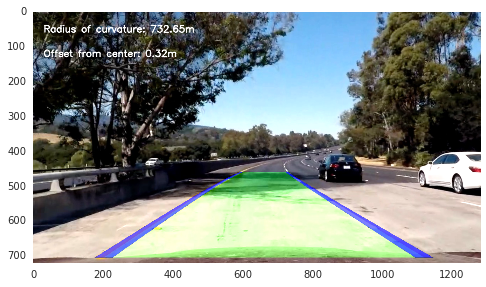

In [256]:
plt.figure(figsize=(8,8))
plt.grid('off')
plt.imshow(cv2.cvtColor(blend, code=cv2.COLOR_BGR2RGB))

### Process video

In [234]:
from moviepy.editor import VideoFileClip

In [291]:
line_lt, line_rt = Line(buffer_len=10), Line(buffer_len=10)
processed_frames = 0
clip = VideoFileClip('project_video.mp4').fl_image(process_pipeline)
clip.write_videofile('project_video_out3.mp4', audio=False)

[MoviePy] >>>> Building video project_video_out3.mp4
[MoviePy] Writing video project_video_out3.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:16<00:00,  4.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out3.mp4 

